<a href="https://colab.research.google.com/github/TomiGarrido/MAT281-Entegrables/blob/main/docs/codes/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [5]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [6]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [7]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [26]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



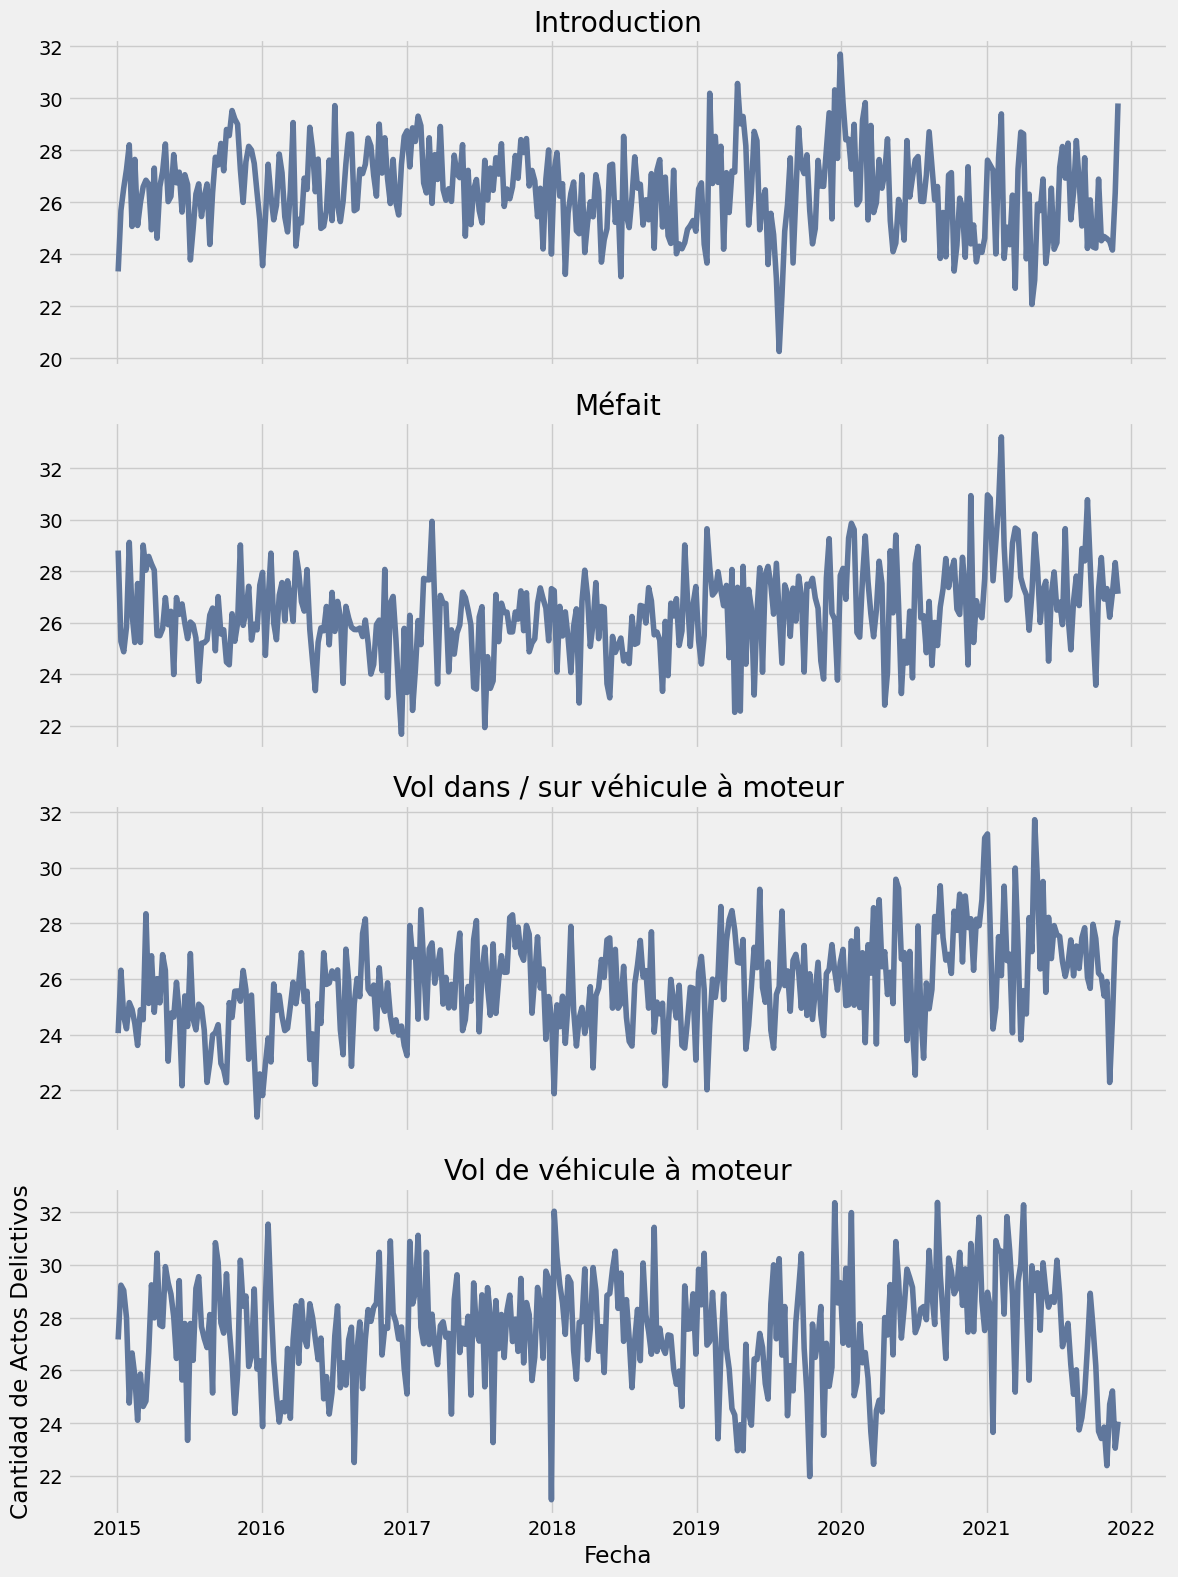

In [9]:
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

axes[0].plot(y_s1)
axes[0].set_title(validate_categorie[0])

axes[1].plot(y_s2)
axes[1].set_title(validate_categorie[1])

axes[2].plot(y_s3)
axes[2].set_title(validate_categorie[2])

axes[3].plot(y_s4)
axes[3].set_title(validate_categorie[3])

plt.xlabel('Fecha')
plt.ylabel('Cantidad de Actos Delictivos')
plt.tight_layout()
plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [10]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

In [11]:
results = []

y_to_model = y_s1

for param in params:
    param_sarima = param[0]
    param_seasonal = param[1]
    try:
        model = SarimaModels(params=[param_sarima, param_seasonal])
        df_metrics = model.metrics(y_to_model, target_date)
        results.append(df_metrics)
    except:
        continue

results_df = pd.concat(results, ignore_index=True)
results_df = results_df.sort_values('rmse')
print(results_df)

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


        mae       mse     rmse    mape   maape   wmape   mmape   smape  \
5    1.5876    3.4224   1.8500  0.0622  0.0620  0.0614  0.0599  0.0614   
13   1.5934    3.4304   1.8521  0.0624  0.0622  0.0616  0.0600  0.0616   
37   1.6021    3.4537   1.8584  0.0627  0.0625  0.0619  0.0603  0.0619   
7    1.6444    3.7833   1.9451  0.0654  0.0651  0.0635  0.0629  0.0635   
3    1.6444    3.7832   1.9451  0.0654  0.0651  0.0635  0.0629  0.0635   
..      ...       ...      ...     ...     ...     ...     ...     ...   
50   7.8111   73.7850   8.5898  0.2988  0.2862  0.3019  0.2877  0.3654   
9   22.8403  550.3448  23.4594  0.8845  0.7122  0.8827  0.8514  1.6822   
1   23.0209  560.5370  23.6757  0.8899  0.7147  0.8896  0.8567  1.7030   
8   25.5633  660.3857  25.6980  0.9886  0.7779  0.9879  0.9517  1.9706   
0   25.8768  672.9892  25.9420  1.0000  0.7854  1.0000  0.9626  2.0000   

                        model  
5   SARIMA_(0,0,0)X(1,0,1,12)  
13  SARIMA_(0,0,1)X(1,0,1,12)  
37  SARIMA_(1,0




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [27]:
from prophet import Prophet

results = []

y_to_model = y_s1

for param in params:
    param_sarima = param[0]
    param_seasonal = param[1]
    try:
        model = SarimaModels(params=[param_sarima, param_seasonal])
        df_metrics = model.metrics(y_to_model, target_date)
        results.append(df_metrics)
    except:
        continue

results_df = pd.concat(results, ignore_index=True)
results_df = results_df.sort_values('rmse')
print(results_df)

best_sarima_metrics = results_df.iloc[[0]]
best_sarima_metrics['model'] = best_sarima_metrics['model'].astype(str)

comparison_metrics = pd.concat([best_sarima_metrics, prophet_metrics], ignore_index=True)

display(comparison_metrics)

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


        mae       mse     rmse    mape   maape   wmape   mmape   smape  \
5    1.5876    3.4224   1.8500  0.0622  0.0620  0.0614  0.0599  0.0614   
13   1.5934    3.4304   1.8521  0.0624  0.0622  0.0616  0.0600  0.0616   
37   1.6021    3.4537   1.8584  0.0627  0.0625  0.0619  0.0603  0.0619   
7    1.6444    3.7833   1.9451  0.0654  0.0651  0.0635  0.0629  0.0635   
3    1.6444    3.7832   1.9451  0.0654  0.0651  0.0635  0.0629  0.0635   
..      ...       ...      ...     ...     ...     ...     ...     ...   
50   7.8111   73.7850   8.5898  0.2988  0.2862  0.3019  0.2877  0.3654   
9   22.8403  550.3448  23.4594  0.8845  0.7122  0.8827  0.8514  1.6822   
1   23.0209  560.5370  23.6757  0.8899  0.7147  0.8896  0.8567  1.7030   
8   25.5633  660.3857  25.6980  0.9886  0.7779  0.9879  0.9517  1.9706   
0   25.8768  672.9892  25.9420  1.0000  0.7854  1.0000  0.9626  2.0000   

                        model  
5   SARIMA_(0,0,0)X(1,0,1,12)  
13  SARIMA_(0,0,1)X(1,0,1,12)  
37  SARIMA_(1,0

/tmp/ipython-input-965381910.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_sarima_metrics['model'] = best_sarima_metrics['model'].astype(str)


,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,1.5876,3.4224,1.8500,0.0622,0.0620,0.0614,0.0599,0.0614,"SARIMA_(0,0,0)X(1,0,1,12)"
1,1.7079,4.1305,2.0324,0.0670,0.0667,0.0660,0.0645,0.0660,Prophet


RESPUESTA:

SARIMA asume que la serie temporal es estacionaria y modela la dependencia lineal entre las observaciones. Por el otro lado, Prohpet utiliza un modelo aditivo que descompone la serie en tendencia, estacionalidad y festivos, siendo más robusto a datos faltantes y cambios abruptos en la tendencia.
* Prophet generalmente es más fácil de usar e interpretar, especialmente para usuarios sin una profunda experiencia en series temporales. Requiere menos preprocesamiento y selección manual de parámetros en comparación con SARIMA.
*Según las métricas mostradas en la tabla comparativa, podemos evaluar qué modelo tuvo un mejor desempeño en este conjunto de datos específico.
* EN conclusión, Prophet puede ser preferible en situaciones donde hay estacionalidad fuerte, falta de datos, valores atípicos o cambios de tendencia claros, y cuando se busca una implementación rápida y sencilla. SARIMA puede ser más adecuado cuando se necesita un modelo más interpretable basado en la estructura de autocorrelación de la serie y cuando se cumplen sus supuestos de estacionariedad

En este caso, basándonos en las métricas, podemos determinar cuál modelo fue más preciso para predecir los actos delictivos de la categoría Introduction en el período de prueba.